In [104]:
# https://rpubs.com/imartinezl/tsclustering

In [105]:
from datasetsforecast.m3 import M3

df = M3().load("../data", group="Monthly")[0]
df.sort_values(["unique_id", "ds"], inplace=True)
data = df.groupby("unique_id").apply(lambda series: series.y.values[:60]).values
data = np.stack(data)

/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


/tmp/ipykernel_17059/682077851.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = df.groupby('unique_id').apply(lambda series: series.y.values[:60] ).values


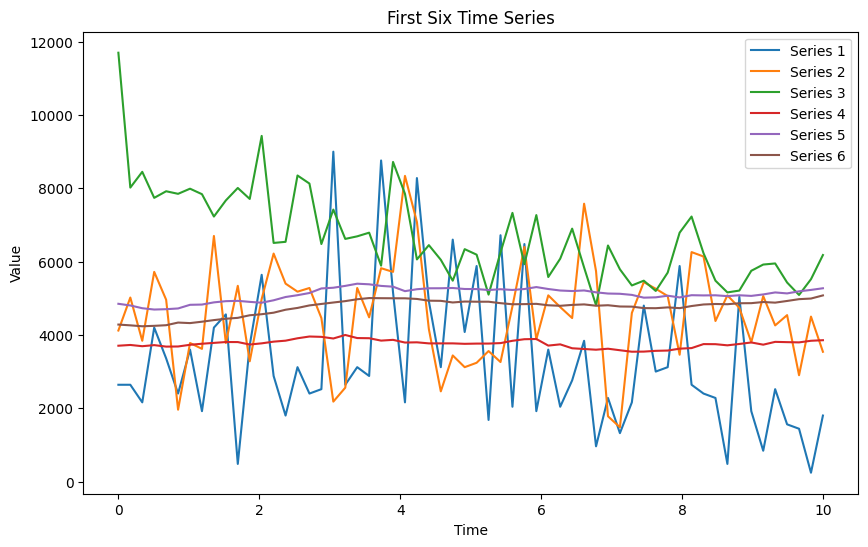

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# # Set random seed for reproducibility
# np.random.seed(123)

# # Generate synthetic time series data (mimicking SyntheticControl)
# n_series, n_points = 100, 60
# t = np.linspace(0, 10, n_points)
# data = []
# for i in range(n_series):
#     # Mix of trends, cycles, and noise
#     trend = 0.1 * i * t if i < 30 else 0
#     cycle = np.sin(2 * np.pi * t * (0.5 + i / 100)) if i < 60 else np.cos(2 * np.pi * t * 0.5)
#     noise = np.random.normal(0, 0.2, n_points)
#     series = trend + cycle + noise
#     data.append(series)
# data = np.array(data)  # Shape: (100, 60)

# 1. Visualize first six time series
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(t, data[i], label=f"Series {i+1}")
plt.title("First Six Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [108]:
# Custom function to compute correlation-based distance matrix


def correlation_distance_matrix(data):
    """
    Compute correlation-based distance matrix using Pearson correlation.
    Distance = sqrt((1 - rho) / 2), where rho is the correlation coefficient.

    Args:
        data (np.ndarray): Time series data of shape (n_series, n_points).

    Returns:
        np.ndarray: Square distance matrix of shape (n_series, n_series).
    """
    # Compute Pearson correlation matrix
    corr_matrix = np.corrcoef(data)
    # Handle numerical instabilities (e.g., values slightly outside [-1, 1])
    corr_matrix = np.clip(corr_matrix, -1, 1)
    # Convert to distance: sqrt((1 - rho) / 2)- is known as the angular distance derived from the Pearson correlation coefficient 𝜌, and it maps correlations to Euclidean-like distances.
    dist_matrix = np.sqrt((1 - corr_matrix) / 2)
    return dist_matrix

In [115]:
from scipy.spatial.distance import squareform

# 2. Compute correlation-based distance matrix
dist_matrix_square = correlation_distance_matrix(data)
dist_matrix = squareform(dist_matrix_square, checks=False)

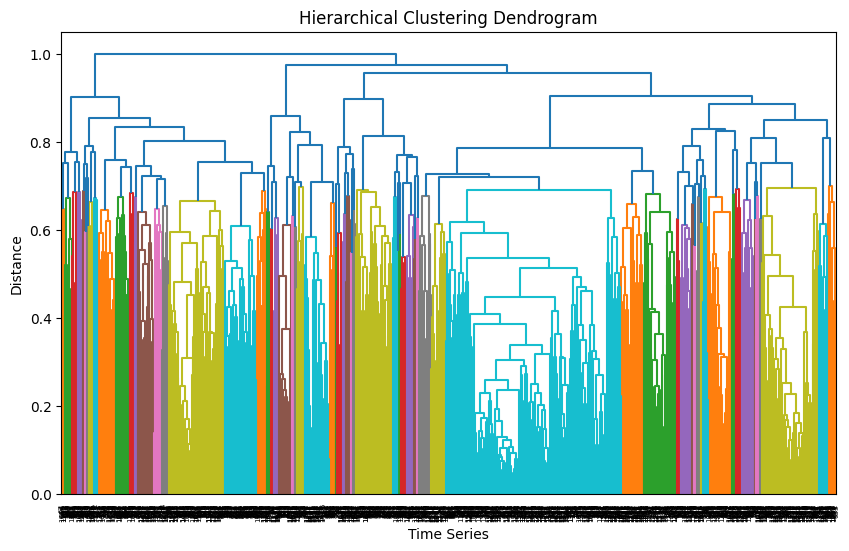

In [117]:
from scipy.cluster.hierarchy import cut_tree, dendrogram, linkage

n_series = data.shape[0]
# 3. Hierarchical clustering
# Perform hierarchical clustering with complete linkage
Z = linkage(dist_matrix, method="complete")
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=np.arange(1, n_series + 1))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Time Series")
plt.ylabel("Distance")
plt.show()

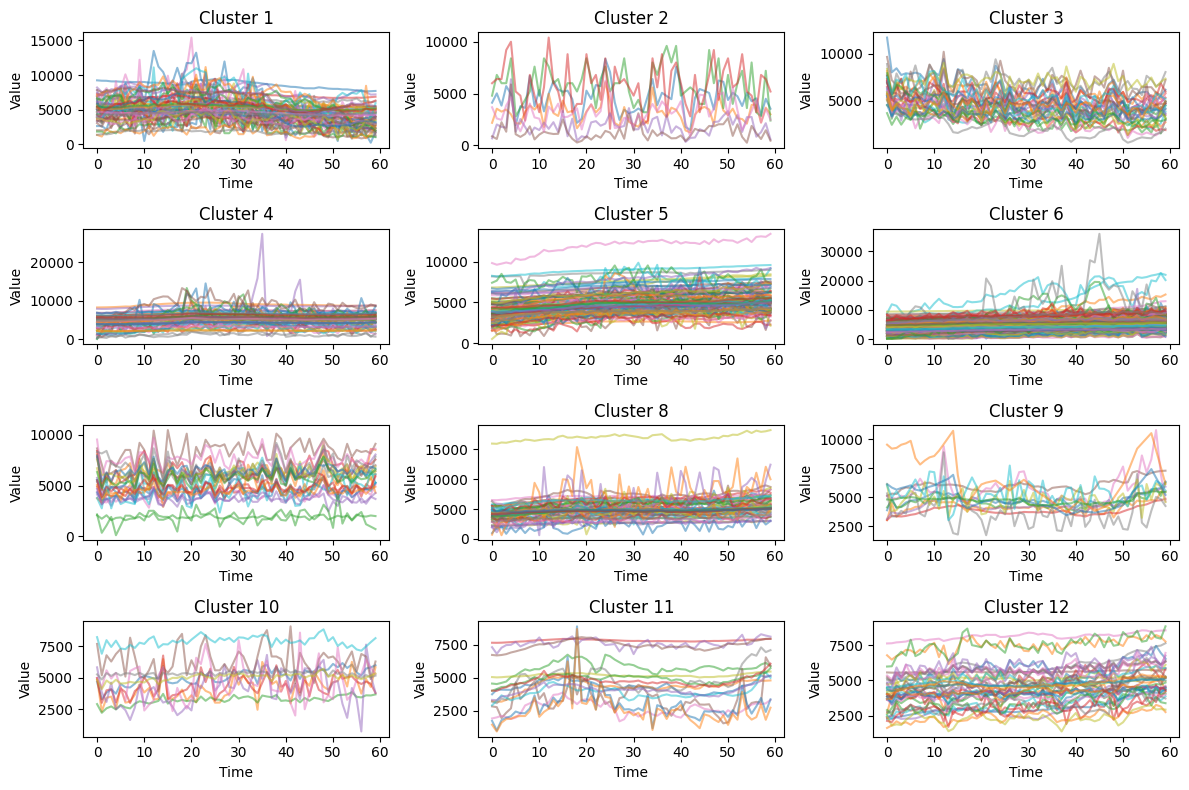

In [124]:
# Cut tree to get 6 clusters
hc_clusters = cut_tree(Z, n_clusters=48).flatten()
# Visualize time series by cluster
plt.figure(figsize=(12, 8))
for cluster in range(12):
    plt.subplot(4, 3, cluster + 1)
    for i in range(n_series):
        if hc_clusters[i] == cluster:
            plt.plot(t, data[i], alpha=0.5)
    plt.title(f"Cluster {cluster + 1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

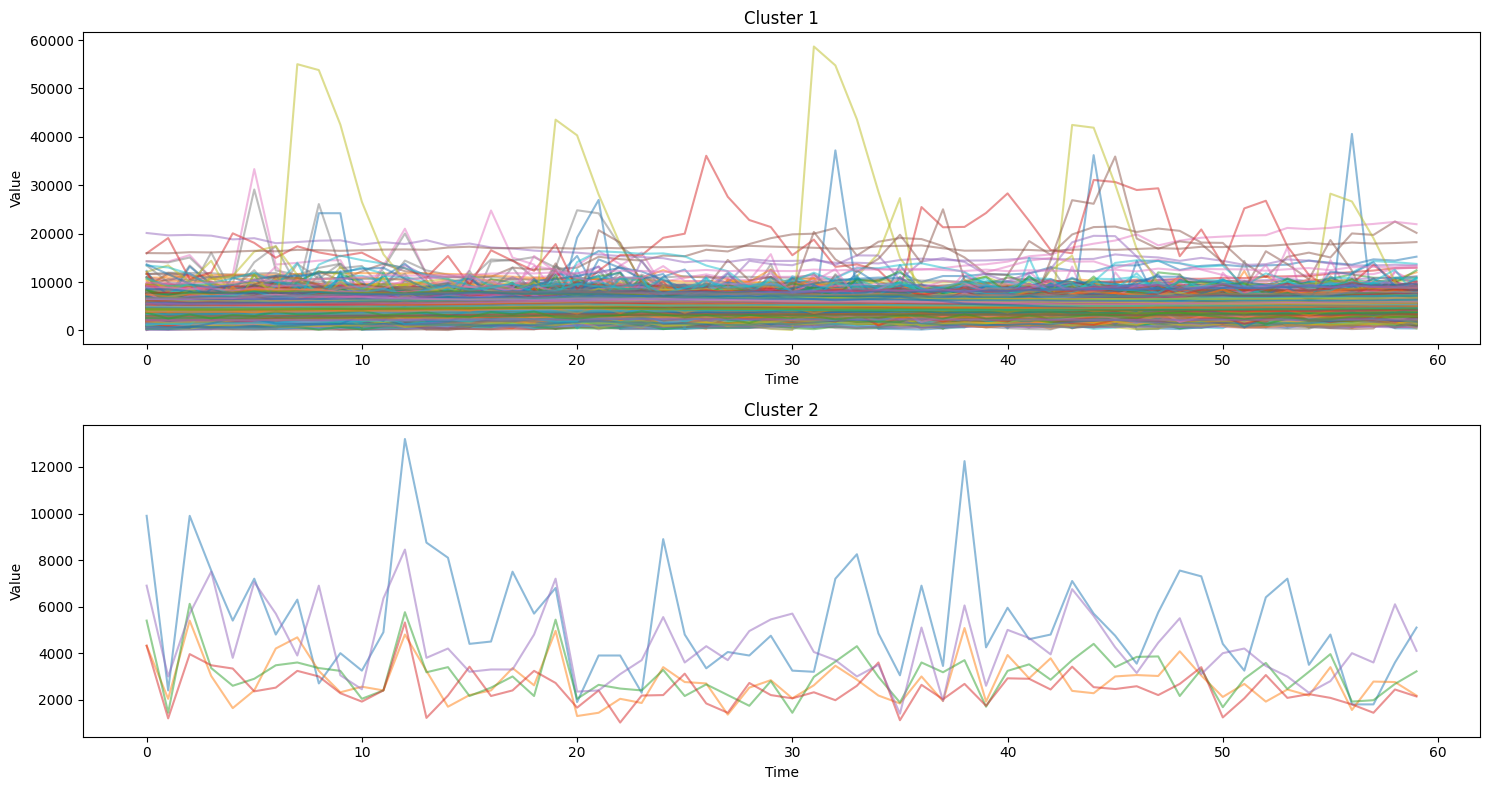

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# DBSCAN with precomputed distance matrix
from sklearn.cluster import DBSCAN

db = DBSCAN(metric="precomputed", eps=0.5, min_samples=5)
labels = db.fit_predict(dist_matrix_square)

# Handle number of series and time axis
n_series = data.shape[0]
t = np.arange(data.shape[1])  # assuming uniform time axis

# Unique cluster labels (excluding noise if any)
unique_labels = np.unique(labels)
n_clusters = len(unique_labels[unique_labels != -1])  # exclude noise

# Visualize time series by cluster
plt.figure(figsize=(15, 8))
plot_index = 1
for cluster in unique_labels:
    if cluster == -1:
        continue  # skip noise points
    plt.subplot(2, (n_clusters + 1) // 2, plot_index)
    for i in range(n_series):
        if labels[i] == cluster:
            plt.plot(t, data[i], alpha=0.5)
    plt.title(f"Cluster {cluster + 1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plot_index += 1

plt.tight_layout()
plt.show()

In [126]:
# from sklearn.metrics import silhouette_score

# # Get mask for non-noise points
# mask = labels != -1

# # Compute silhouette score using the same precomputed distance matrix
# if np.unique(labels[mask]).size > 1:
#     sil_score = silhouette_score(dist_matrix_square[mask][:, mask], labels[mask], metric="precomputed")
#     print(f"Silhouette Score (excluding noise): {sil_score:.4f}")
# else:
#     print("Silhouette Score cannot be computed: only one cluster found.")

/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


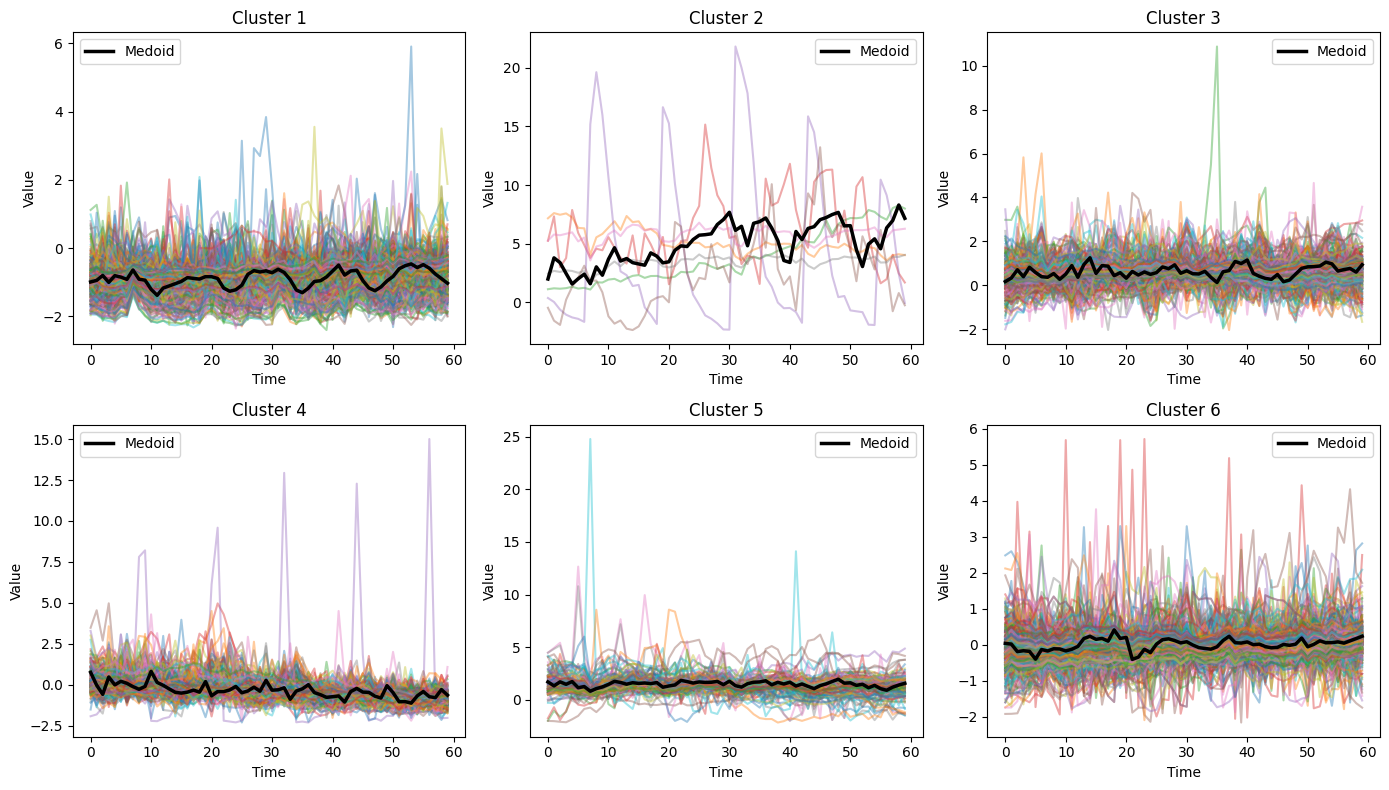

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw  # or cdist_euclidean

# Assume `data` is your (n_series, n_points) array
n_clusters = 6
n_series, n_points = data.shape

# Normalize each series
data_scaled = StandardScaler().fit_transform(data.reshape(-1, n_points)).reshape(data.shape)

# Cluster using DTW or Euclidean
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=123)
pam_clusters = kmeans.fit_predict(data_scaled)

# Precompute distance matrix (pairwise distances between all time series)
dist_matrix = cdist_dtw(data_scaled)  # shape (n_series, n_series)

# Find medoids


def find_medoids(data, clusters, dist_matrix, n_clusters):
    medoids = []
    for k in range(n_clusters):
        cluster_indices = np.where(clusters == k)[0]
        if len(cluster_indices) > 0:
            cluster_dists = dist_matrix[cluster_indices][:, cluster_indices]
            medoid_idx = cluster_indices[np.argmin(cluster_dists.sum(axis=1))]
            medoids.append(medoid_idx)
    return medoids


medoids = find_medoids(data_scaled, pam_clusters, dist_matrix, n_clusters)

# Visualize clusters
plt.figure(figsize=(14, 8))
for cluster in range(n_clusters):
    plt.subplot(2, 3, cluster + 1)
    for i in range(n_series):
        if pam_clusters[i] == cluster:
            plt.plot(np.arange(n_points), data_scaled[i], alpha=0.4)
    # Highlight medoid
    plt.plot(
        np.arange(n_points),
        data_scaled[medoids[cluster]],
        color="black",
        linewidth=2.5,
        label="Medoid",
    )
    plt.title(f"Cluster {cluster + 1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
plt.tight_layout()
plt.show()

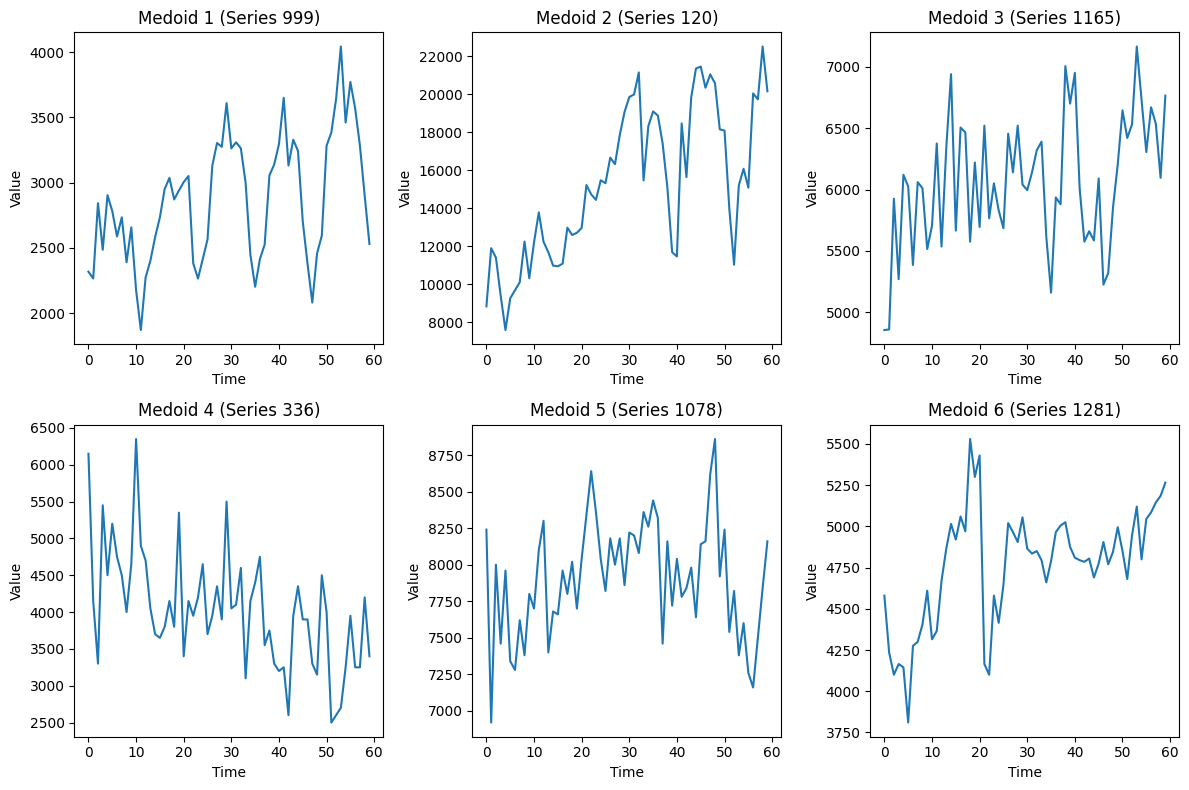

In [128]:
# Visualize medoids
plt.figure(figsize=(12, 8))
for i, medoid_idx in enumerate(medoids):
    plt.subplot(2, 3, i + 1)
    plt.plot(t, data[medoid_idx])
    plt.title(f"Medoid {i + 1} (Series {medoid_idx + 1})")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [129]:
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

# Ensure the diagonal of the distance matrix is zero
np.fill_diagonal(dist_matrix_square, 0)

# 6. Cluster validation (silhouette)
# Silhouette for hierarchical clustering
hc_silhouette = silhouette_score(dist_matrix_square, hc_clusters, metric="precomputed")
hc_sil_samples = silhouette_samples(dist_matrix_square, hc_clusters, metric="precomputed")

# Silhouette for PAM
pam_silhouette = silhouette_score(dist_matrix_square, pam_clusters, metric="precomputed")
pam_sil_samples = silhouette_samples(dist_matrix_square, pam_clusters, metric="precomputed")

# # Plot silhouette for hierarchical clustering
# plt.figure(figsize=(10, 6))
# y_lower = 10
# for i in range(6):
#     cluster_sil = hc_sil_samples[hc_clusters == i]
#     cluster_sil.sort()
#     size_cluster = cluster_sil.shape[0]
#     y_upper = y_lower + size_cluster
#     plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, alpha=0.7)
#     y_lower = y_upper + 10
# plt.title(f"Silhouette Plot for Hierarchical Clustering (Avg: {hc_silhouette:.3f})")
# plt.xlabel("Silhouette Coefficient")
# plt.ylabel("Cluster Label")
# plt.axvline(x=hc_silhouette, color="red", linestyle="--")
# plt.show()

# # Plot silhouette for PAM
# plt.figure(figsize=(10, 6))
# y_lower = 10
# for i in range(6):
#     cluster_sil = pam_sil_samples[pam_clusters == i]
#     cluster_sil.sort()
#     size_cluster = cluster_sil.shape[0]
#     y_upper = y_lower + size_cluster
#     plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, alpha=0.7)
#     y_lower = y_upper + 10
# plt.title(f"Silhouette Plot for PAM Clustering (Avg: {pam_silhouette:.3f})")
# plt.xlabel("Silhouette Coefficient")
# plt.ylabel("Cluster Label")
# plt.axvline(x=pam_silhouette, color="red", linestyle="--")
# plt.show()

# Print average silhouette scores
print(f"Average Silhouette Score (Hierarchical): {hc_silhouette:.3f}")
print(f"Average Silhouette Score (PAM): {pam_silhouette:.3f}")

Average Silhouette Score (Hierarchical): 0.065
Average Silhouette Score (PAM): -0.035
